In [37]:
# Set current working directory
import os
curr_dir = os.getcwd()

1. Electricty price data


In [38]:
from datetime import datetime, timedelta

import requests
import lxml.html as lh
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup

In [39]:
url = 'https://www.epexspot.com/fr/donnees_de_marche/dayaheadfixing/auction-table/2018-01-14/FR'

def parse_price_table(url):

    # Get HTML content of url webpage
    page = requests.get(url).text
    # Creat BeautifulSoup object
    soup = BeautifulSoup(page, 'lxml')
    # Isolate and store hourly price table
    hours_table = soup.find_all('table')[2]
    df = pd.read_html(str(hours_table), thousands = ' ', decimal=',')[0]
  
    # Clean dataframe 
    df.rename(columns={'Unnamed: 0':'Time', 'Unnamed: 1':'Unit'}, inplace=True)
    df = df.fillna(method = 'ffill')
    df.replace(to_replace = "â¬/MWh", value = "€/MWh", inplace=True)
    
    # Re-shape dataframe
    df = df.set_index(['Time','Unit'])
    df = df.transpose().stack('Time')

    return df

In [40]:
def get_week_data(start_datetime):
    """
    Scraps electrcity price for the week preceding date given (included)
    """
    
    # Time reference variables
    week_end = start_datetime + timedelta(6)
   
    # URL of page hosting data for given week
    url = f'https://www.epexspot.com/fr/donnees_de_marche/dayaheadfixing/auction-table/{week_end.date()}/FR' 
    
    # Parse data table on Epex Spot 
    week_data = parse_price_table(url)
    
    # TEMPORARY FIX - drop extra observation
    if week_end == datetime(2018, 10, 28):
        week_data.drop('02b - 03', level='Time', inplace = True)

    # Create time index by hour
    datetime_index = [start_datetime + timedelta(hours = i) for i in range(0, 24*7)]

    # Change dataframe index to hours
    week_data.index = datetime_index
    
    return week_data

In [41]:
# Create dataframe to store parsed data
FR_price_data = pd.DataFrame()

#initialize loop
current_date = datetime(2018, 1, 1)

while current_date.year < 2019:
    # fetch data of corresponding week
    week_data = get_week_data(current_date)
    # add week data to dataframe
    FR_price_data = pd.concat([FR_price_data, week_data])
    # increment one week
    current_date = current_date + timedelta(7)

elec_price_2018 = FR_price_data[FR_price_data.index.year.isin(['2018'])]
elec_price_2018.index.names = ['Date']

In [43]:
# Save grid price data in a csv
elec_price_2018.to_csv('FR_grid_price.csv')

2. EV Unit production

In [44]:
pip install DateTimeRange

Note: you may need to restart the kernel to use updated packages.


In [45]:
import datetimerange
import math
from datetimerange import DateTimeRange

time_range = DateTimeRange("2018-01-01T00:00:00", "2018-12-31T23:00:00")
year_hours = list(time_range.range(timedelta(hours=1)))


In [54]:
# Five PV units production data
unit_assumptions = {
    'Unit 1': {'Capacity' : 8, 'LCOE': 3.5},
    'Unit 2': {'Capacity' : 12, 'LCOE': 1.25},
    'Unit 3': {'Capacity' : 7, 'LCOE': 30.5},
    'Unit 4': {'Capacity' : 3, 'LCOE': 13.5},
    'Unit 5': {'Capacity' : 5, 'LCOE': 0.5}
    }

# Save assumptions in a csv
pd.DataFrame(data = unit_assumptions).to_csv('PV_settings.csv')

In [56]:
# Generate production data of each PV unit
unit_output = {}

for key in unit_assumptions.keys():
    unit_output[key] = [math.sin(-(hour.hour - 8)/(8-19) * math.pi) * np.random.uniform(0.7,1.1) * unit_assumptions[key]['Capacity'] if (hour.hour >= 8 and hour.hour < 19) else 0 for hour in year_hours]

In [57]:
# Save PV units output and price data in a csv
PV_output = pd.DataFrame(data = unit_output, index = year_hours)
PV_output.to_csv('PV_output.csv')

3. Prelimary Exploration

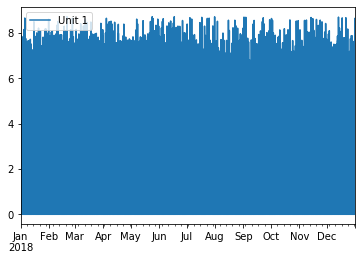

In [58]:
# Sandbox to explore parsed/generated data

plot = PV_output.plot(y='Unit 1', use_index=True)